# Rakan's Playground




## Setup

### Package Installing

In [66]:
!pip install spotipy

### Google Drive & Path

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

### Internal Imports

In [19]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, SpotifyTracksDataset, normalize_data_by_type, normalize_data, NormalizationType

In [20]:
sp = get_spotify_connection()

### PyTorch/Numpy/Pandas

In [21]:
import numpy as np
import pandas as pd
import random

pd.options.mode.chained_assignment = None  # default='warn'

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

In [24]:
pl = PL.load_playlist(PROJECT_ROOT + "playlist_2sRZldX6n9oaII70OoO3zB")

Loaded playlist from file: /content/drive/My Drive/UofT/APS360/Project/Hit-Song-Prediction/playlist_2sRZldX6n9oaII70OoO3zB


In [78]:
information_df = pd.DataFrame()

''' Audio Features '''
information_df['key'] = pd.Series([x['key'] for x in pl.playlist_information.track_features.values])
information_df['mode'] = pd.Series([x['mode'] for x in pl.playlist_information.track_features.values])
information_df['time_signature'] = pd.Series([x['time_signature'] for x in pl.playlist_information.track_features.values])
information_df['duration'] = pd.Series([x['duration_ms'] / 1000 for x in pl.playlist_information.track_features.values])
information_df['acousticness'] = pd.Series([x['acousticness'] for x in pl.playlist_information.track_features.values])
information_df['danceability'] = pd.Series([x['danceability'] for x in pl.playlist_information.track_features.values])
information_df['energy'] = pd.Series([x['energy'] for x in pl.playlist_information.track_features.values])
information_df['instrumentalness'] = pd.Series([x['instrumentalness'] for x in pl.playlist_information.track_features.values])
information_df['liveness'] = pd.Series([x['liveness'] for x in pl.playlist_information.track_features.values])
information_df['loudness'] = pd.Series([x['loudness'] for x in pl.playlist_information.track_features.values])
information_df['speechiness'] = pd.Series([x['speechiness'] for x in pl.playlist_information.track_features.values])
information_df['valence'] = pd.Series([x['valence'] for x in pl.playlist_information.track_features.values])
information_df['tempo'] = pd.Series([x['tempo'] for x in pl.playlist_information.track_features.values])

''' Track Info '''
information_df['explicit'] = pd.Series([x['explicit'] for x in pl.playlist_information.track_info.values])
information_df['release_date'] = pd.Series([x['album']['release_date'] for x in pl.playlist_information.track_info.values])

''' Artist Info '''
information_df['artist_followers'] = pd.Series([np.array([x['followers']['total'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
information_df['max_artist_popularity'] = pd.Series([np.array([x['popularity'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
information_df['avg_popularity_artist_top_tracks'] = pl.artist_top_track_information_df['avg_popularity_artist_top_tracks']
information_df['avg_duration_artist_top_tracks'] = pl.artist_top_track_information_df['avg_duration_artist_top_tracks']
information_df['avg_acousticness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks']
information_df['avg_danceability_artist_top_tracks'] = pl.artist_top_track_information_df['avg_danceability_artist_top_tracks']
information_df['avg_energy_artist_top_tracks'] = pl.artist_top_track_information_df['avg_energy_artist_top_tracks']
information_df['avg_instrumentalness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks']
information_df['avg_liveness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_liveness_artist_top_tracks']
information_df['avg_loudness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_loudness_artist_top_tracks']
information_df['avg_speechiness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks']
information_df['avg_valence_artist_top_tracks'] = pl.artist_top_track_information_df['avg_valence_artist_top_tracks']
information_df['avg_tempo_artist_top_tracks'] = pl.artist_top_track_information_df['avg_tempo_artist_top_tracks']

information_df['change_from_avg_duration_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_duration_artist_top_tracks'] - information_df.duration).abs()
information_df['change_from_avg_acousticness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks'] - information_df.acousticness).abs()
information_df['change_from_avg_danceability_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_danceability_artist_top_tracks'] - information_df.danceability).abs()
information_df['change_from_avg_energy_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_energy_artist_top_tracks'] - information_df.energy).abs()
information_df['change_from_avg_instrumentalness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks'] - information_df.instrumentalness).abs()
information_df['change_from_avg_liveness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_liveness_artist_top_tracks'] - information_df.liveness).abs()
information_df['change_from_avg_loudness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_loudness_artist_top_tracks'] - information_df.loudness).abs()
information_df['change_from_avg_speechiness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks'] - information_df.speechiness).abs()
information_df['change_from_avg_valence_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_valence_artist_top_tracks'] - information_df.valence).abs()
information_df['change_from_avg_tempo_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_tempo_artist_top_tracks'] - information_df.tempo).abs()

''' Target '''
information_df['popularity'] = pd.Series([x['popularity'] for x in pl.playlist_information.track_info.values])


''' Genres '''
genres_df = pl.genres_df

In [82]:
def get_balanced_classification_df(df, hit_cutoff):

  main_df = df.copy()

  # hit_df = main_df[main_df.popularity > hit_cutoff]
  # non_hit_df = main_df[main_df.popularity <= hit_cutoff]
  hit_df = main_df[main_df.hit == 1]
  non_hit_df = main_df[main_df.hit == 0]

  hit_count = hit_df.shape[0]
  non_hit_count = non_hit_df.shape[0]

  if hit_count > non_hit_count:
    diff = hit_count - non_hit_count
    for i in range(0, int(diff/non_hit_count)):
      extra_data = non_hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)

    extra_data = non_hit_df.iloc[0:int(diff%non_hit_count)]
    main_df = main_df.append(extra_data, ignore_index=True)

  else:

    while hit_count < non_hit_count:
      diff = non_hit_count - hit_count
      extra_data = hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)

      # hit_df = main_df[main_df.popularity > hit_cutoff]
      # non_hit_df = main_df[main_df.popularity <= hit_cutoff]

      hit_df = main_df[main_df.hit == 1]
      non_hit_df = main_df[main_df.hit == 0]

      hit_count = hit_df.shape[0]
      non_hit_count = non_hit_df.shape[0]

  return main_df


# information_df = get_balanced_classification_df(information_df, 70)
# hit_df = new_df[new_df.popularity > 70]
# non_hit_df = new_df[new_df.popularity <= 70]
# num_samples = new_df.shape[0]
# hit_count = hit_df.shape[0]
# non_hit_count = non_hit_df.shape[0]
# print(num_samples)
# print(hit_count)
# print(non_hit_count)




In [69]:
target = 'popularity'
features = list(information_df.columns.copy())
features.remove(target)
print(f"Features: {features}")
genres = list(genres_df.columns.copy())
print(f"Genres: {genres}")

regression_target = "popularity"
classification_target = "hit"
print(f"Regression Target: {regression_target}")
print(f"Classification Target: {classification_target}")

Features: ['key', 'mode', 'time_signature', 'duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'explicit', 'release_date', 'artist_followers', 'max_artist_popularity', 'avg_popularity_artist_top_tracks', 'avg_duration_artist_top_tracks', 'avg_acousticness_artist_top_tracks', 'avg_danceability_artist_top_tracks', 'avg_energy_artist_top_tracks', 'avg_instrumentalness_artist_top_tracks', 'avg_liveness_artist_top_tracks', 'avg_loudness_artist_top_tracks', 'avg_speechiness_artist_top_tracks', 'avg_valence_artist_top_tracks', 'avg_tempo_artist_top_tracks', 'change_from_avg_duration_artist_top_tracks', 'change_from_avg_acousticness_artist_top_tracks', 'change_from_avg_danceability_artist_top_tracks', 'change_from_avg_energy_artist_top_tracks', 'change_from_avg_instrumentalness_artist_top_tracks', 'change_from_avg_liveness_artist_top_tracks', 'change_from_avg_loudness_artist_top_tracks', 'change_from_avg_speechin

## Cleaning Data


In [79]:
df = information_df.copy()

In [80]:
''' Discrete''' 
df.time_signature = normalize_data_by_type(df.time_signature, NormalizationType.DEFAULT)
df.key = normalize_data_by_type(df.key, NormalizationType.DEFAULT)
df.explicit = df.explicit *1
df.release_date = 2020 - pd.to_datetime(df.release_date).dt.year
df.release_date = normalize_data_by_type(df.release_date, NormalizationType.DEFAULT)

''' Continuous'''
df.duration = normalize_data_by_type(df.duration, NormalizationType.STD_CLAMP)
df.avg_duration_artist_top_tracks = normalize_data_by_type(df.avg_duration_artist_top_tracks, NormalizationType.STD_CLAMP)
df.change_from_avg_duration_artist_top_tracks = normalize_data(df.change_from_avg_duration_artist_top_tracks, data_min=0, data_max=information_df.duration.max()-information_df.duration.min())

df.tempo = normalize_data_by_type(df.tempo,NormalizationType.DEFAULT)
df.avg_tempo_artist_top_tracks = normalize_data(df.avg_tempo_artist_top_tracks, data_min=information_df.tempo.min(), data_max=information_df.tempo.max())
df.change_from_avg_tempo_artist_top_tracks = normalize_data(df.change_from_avg_tempo_artist_top_tracks, data_min=0, data_max=information_df.tempo.max()-information_df.tempo.min())

df.loudness = normalize_data_by_type(df.loudness, NormalizationType.DEFAULT)
df.avg_loudness_artist_top_tracks = normalize_data(df.avg_loudness_artist_top_tracks, data_min=information_df.loudness.min(), data_max=information_df.loudness.max())
df.change_from_avg_loudness_artist_top_tracks = normalize_data(df.change_from_avg_loudness_artist_top_tracks, data_min=0, data_max=information_df.loudness.max()-information_df.loudness.min())

df.artist_followers = normalize_data_by_type(df.artist_followers, NormalizationType.DEFAULT)

df.max_artist_popularity = normalize_data(df.max_artist_popularity, data_min=0, data_max=100)
df.avg_popularity_artist_top_tracks = normalize_data(df.avg_popularity_artist_top_tracks, data_min=0, data_max=100)

full_df = df

''' Add genre data '''
# full_df = pd.concat([df, genres_df], axis=1, sort=False)

''' Drop missing data '''
full_df.dropna(inplace=True)

regression_df = full_df.copy()
regression_df = regression_df[regression_df.popularity > 10]

classification_df = full_df.copy()
# classification_df = classification_df[classification_df.popularity > 10]
classification_df['hit'] = (classification_df.popularity > 70)*1
classification_df = classification_df.drop("popularity", axis=1)

print(f"Total Number of Tracks: {regression_df.shape[0]}")

print()

print(f"Number of Hits: {classification_df.hit.sum()}")
print(f"Total Number of Tracks: {classification_df.shape[0]}")

Total Number of Tracks: 4094

Number of Hits: 846
Total Number of Tracks: 5493


## Exploring Data

In [62]:
classification_df.corr()['hit']


key                                                   0.018257
mode                                                 -0.028675
time_signature                                        0.095893
duration                                             -0.100314
acousticness                                         -0.157749
danceability                                          0.238682
energy                                                0.134415
instrumentalness                                     -0.347742
liveness                                             -0.002489
loudness                                              0.267110
speechiness                                           0.007133
valence                                               0.181869
tempo                                                 0.068651
explicit                                              0.103324
release_date                                          0.047666
artist_followers                                      0

In [31]:
def plot_feature_and_target(dataframe_to_plot, feature, target):
  cols = [feature, target]
  dataframe_to_plot = dataframe_to_plot[cols]
  dataframe_to_plot.plot.scatter(x=feature, y=target)
  return

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


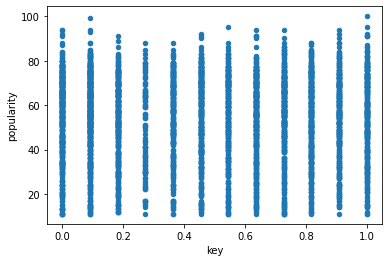

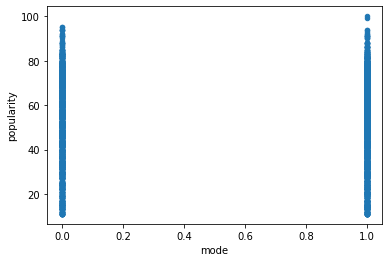

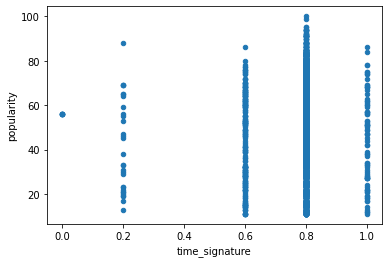

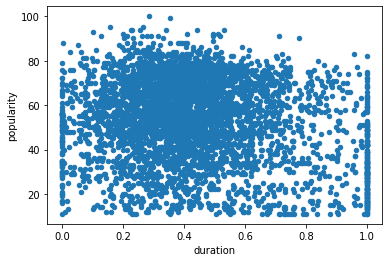

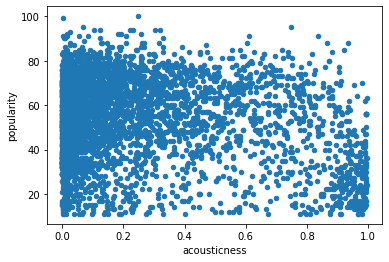

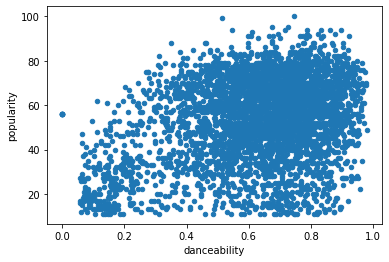

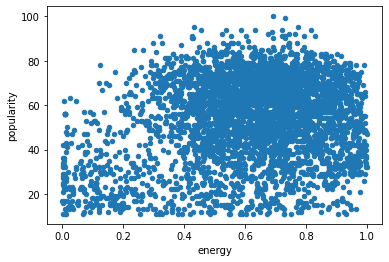

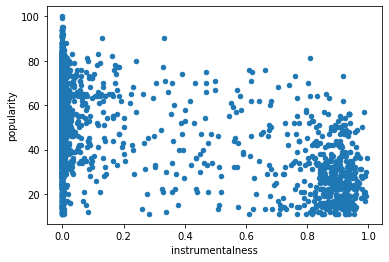

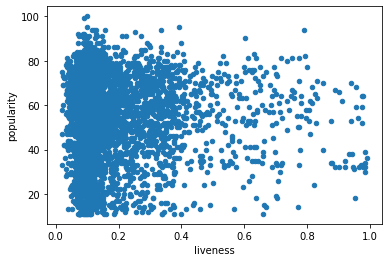

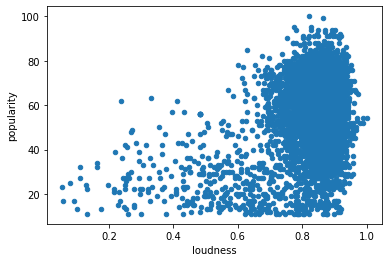

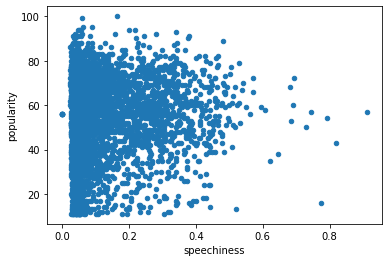

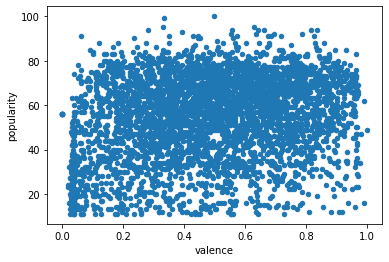

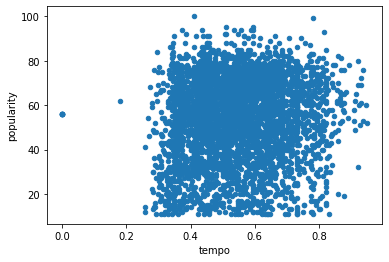

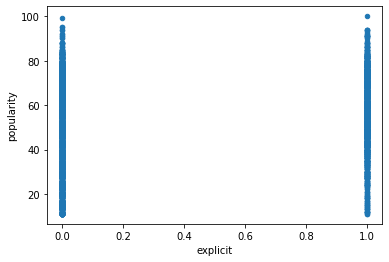

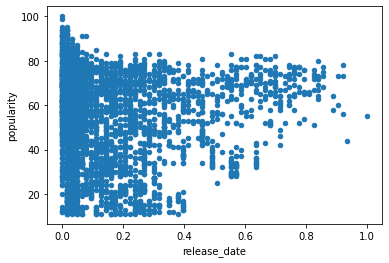

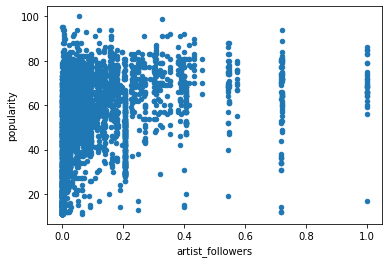

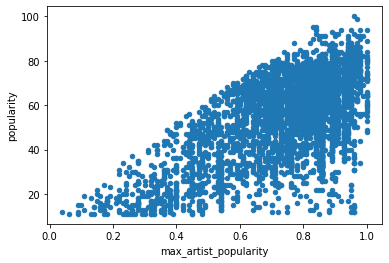

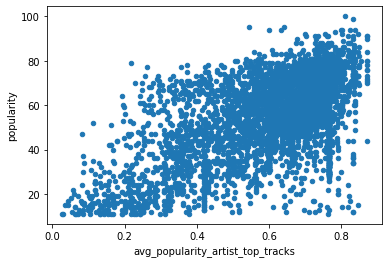

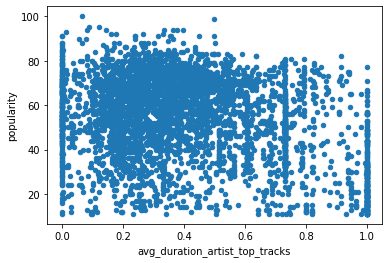

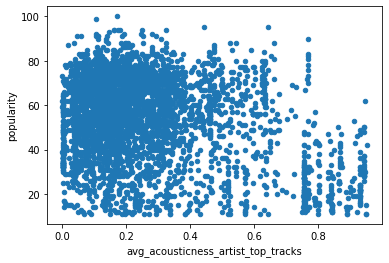

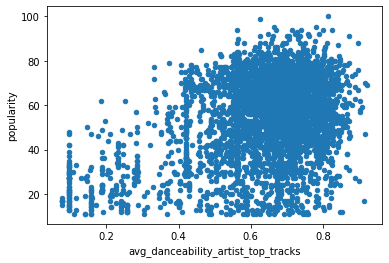

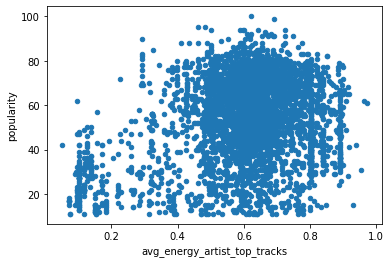

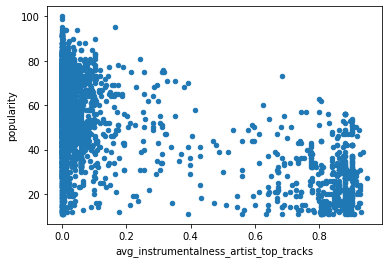

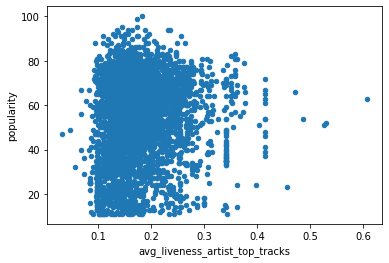

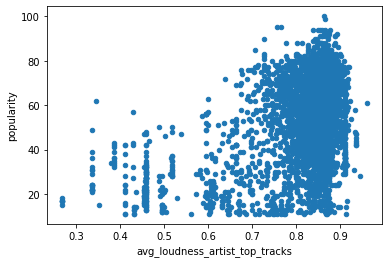

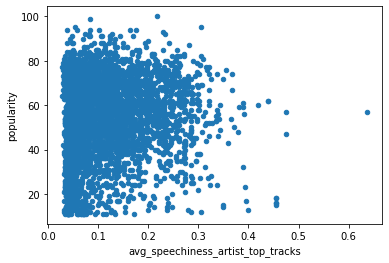

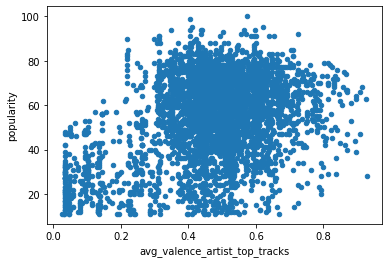

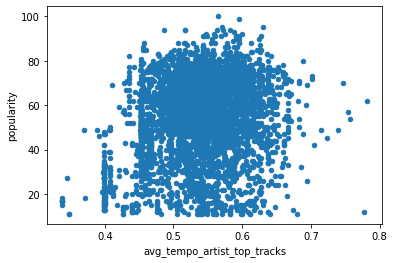

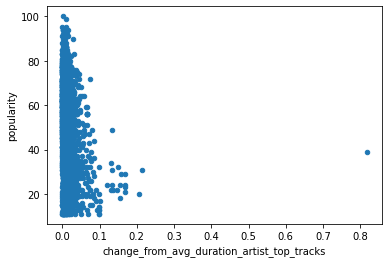

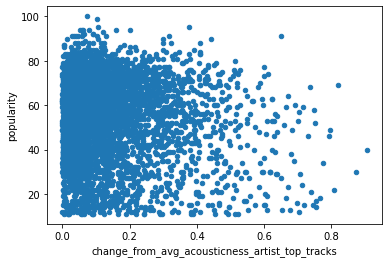

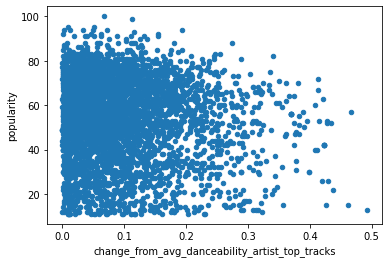

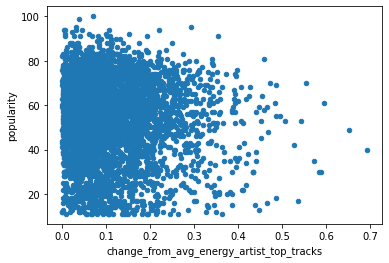

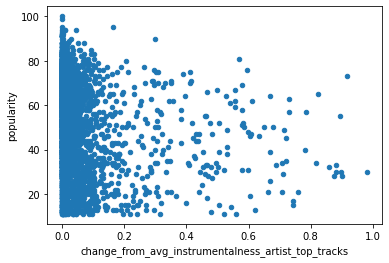

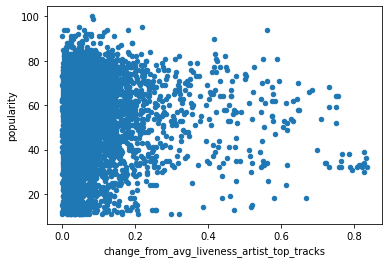

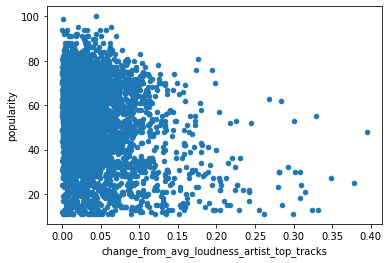

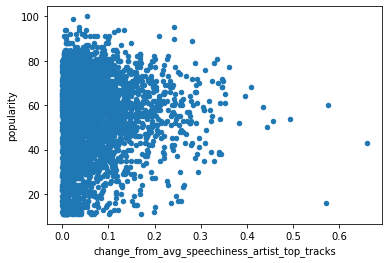

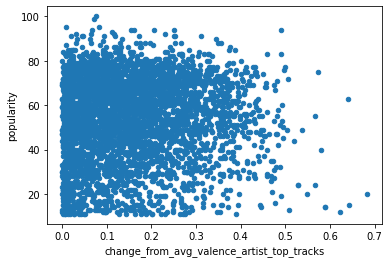

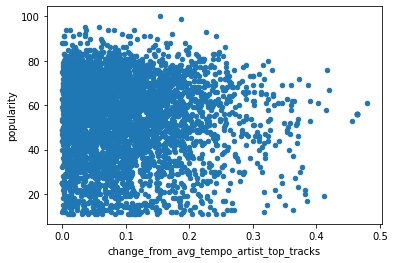

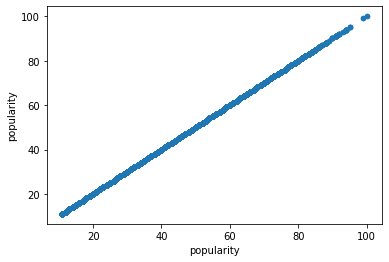

In [32]:
dataframe_to_plot = regression_df
target = regression_target

for col in dataframe_to_plot.columns:
  plot_feature_and_target(dataframe_to_plot, col, target)

## Creating Dataset

In [83]:
TRAIN_PCT = 0.7
VALID_PCT = 0.15

dataframe_to_use = classification_df
dataset_target = classification_target
features = list(dataframe_to_use.columns.copy())
features.remove(dataset_target)

''' Scramble DataFrame '''
seed_torch(0)
dataframe_to_use = dataframe_to_use.sample(frac=1).reset_index(drop=True)

''' Split Data '''
num_data = dataframe_to_use.shape[0]

num_train = int(num_data * TRAIN_PCT)
num_val = int(num_data * VALID_PCT)
num_test = num_data - num_train - num_val

train_df = dataframe_to_use.iloc[0:num_train]
train_df = get_balanced_classification_df(train_df, 70)
val_df = dataframe_to_use.iloc[num_train:num_train+num_val]
test_df = dataframe_to_use.iloc[num_train+num_val:num_data]

''' Create Datasets '''
train = SpotifyTracksDataset(train_df, features, dataset_target)
val = SpotifyTracksDataset(val_df, features, dataset_target)
test = SpotifyTracksDataset(test_df, features, dataset_target)
full_dataset = SpotifyTracksDataset(dataframe_to_use, features, dataset_target)

In [65]:
print(train_df[train_df.hit == 1].shape[0] / train_df.shape[0])
print(val_df[val_df.hit == 1].shape[0] / val_df.shape[0])
print(test_df[test_df.hit == 1].shape[0] / test_df.shape[0])

0.5000768167153172
0.5071736011477762
0.49426934097421205


## Model

### Regression

In [ ]:
class RegressionNet(nn.Module):
  def __init__(self):
    super(RegressionNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

### Classification

In [45]:
class ClassificationNet(nn.Module):
  def __init__(self):
    super(ClassificationNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [35]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    k = random.randint(0, len(data)-1)
    features, target = data[k]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

In [36]:
import matplotlib.pyplot as plt

def subsample_series(series, subsampling=1):
  '''
  Subsamples data series
  '''
  indices = np.arange(0,len(series),subsampling)
  subsampled_series = series[indices]
  return indices + 1, subsampled_series

def plot_data(data, multiple_series=False, subsampling=1, labels=None, title="", xlabel="", ylabel=""):
    plt.title(title)
    
    n = len(data)

    if multiple_series:
      for i, series in enumerate(data, 0):
        indices, subsampled_series = subsample_series(np.array(series), subsampling=subsampling)
        if labels:
          plt.plot(indices, subsampled_series, label=labels[i])
        else:
          plt.plot(indices, subsampled_series,)
    else:
      indices, subsampled_series = subsample_series(np.array(data), subsampling=subsampling)
      if labels:
          plt.plot( indices, subsampled_series, label=labels)
      else:
        plt.plot( indices, subsampled_series)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if labels:
      plt.legend(loc='best')

    plt.show()

#### Regression

In [ ]:
def get_error_regression(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)
  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

def get_stats_regression(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0.0
  total_loss = 0.0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error = total_error/len(data)
  return error, avg_loss

#### Classification

In [37]:
def get_error_classification(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()
  
  error_rate = 1 - (total_error/len(data))
  return error_rate

def get_stats_classification(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0
  total_loss = 0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error_rate = 1 - (total_error/len(data))
  return error_rate, avg_loss

### Train Function

#### Regression

In [ ]:
def train_net_regression(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0.0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate, val_loss = get_stats_regression(model, valid_data, criterion, bs=bs)
    model.train()

    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print()
    predict_some(model, train_data, 2)
    print()
    predict_some(model, valid_data, 2)
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Avg Error by Epoch", xlabel='Epoch', ylabel='Avg Error')

#### Classification

In [38]:
def train_net_classification(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)

      targets = targets.squeeze(1).long()
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      out = torch.softmax(out, dim=1)

      epoch_loss += loss.item()
      epoch_error += out.argmax(dim=1).eq(targets).sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = 1 - (epoch_error / len(train_data))
    val_error_rate, val_loss = get_stats_classification(model, valid_data, criterion, bs=bs)
    model.train()
    
    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Accuracy by Epoch", xlabel='Epoch', ylabel='Error Rate')

### Training Model

#### Regression

In [ ]:
model = RegressionNet()
model.to(device)

train_net_regression(model, train, val, bs=512, lr=0.0001, wd=0, epochs=1000)

NameError: ignored

#### Classification

Epoch 1
  Train Error: 0.5
  Valid Error: 0.8055893074119076
  Train Loss: 0.7005282594607427
  Valid Loss: 0.7064805030822754


Epoch 2
  Train Error: 0.41276202219482117
  Valid Error: 0.31834750911300125
  Train Loss: 0.6804085419728205
  Valid Loss: 0.6660335958003998


Epoch 3
  Train Error: 0.3723797780517879
  Valid Error: 0.448359659781288
  Train Loss: 0.6481254834395188
  Valid Loss: 0.6489343643188477


Epoch 4
  Train Error: 0.35249691738594324
  Valid Error: 0.44957472660996356
  Train Loss: 0.6070822981687692
  Valid Loss: 0.6230949461460114


Epoch 5
  Train Error: 0.3195129469790382
  Valid Error: 0.3001215066828675
  Train Loss: 0.5741110856716449
  Valid Loss: 0.5819730758666992


Epoch 6
  Train Error: 0.29839704069050554
  Valid Error: 0.3232077764277035
  Train Loss: 0.5523464817267197
  Valid Loss: 0.5856818556785583


Epoch 7
  Train Error: 0.27758939580764486
  Valid Error: 0.3754556500607533
  Train Loss: 0.5351321926483741
  Valid Loss: 0.6068897843360901


Ep

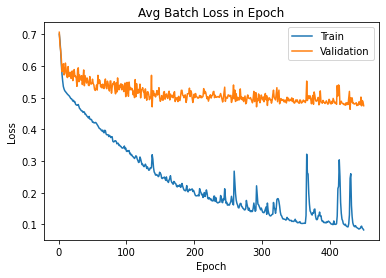

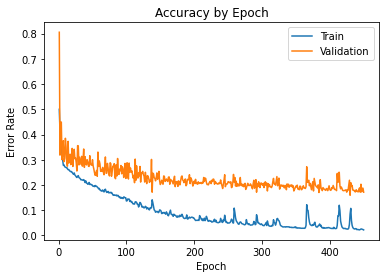

In [87]:
model = ClassificationNet()
model.to(device)

train_net_classification(model, train, val, bs=512, lr=0.001, wd=0, epochs=450)

## Evaluation

In [60]:
def get_baseline_regression_error(df):
  total_error = 0
  # errors = (df.max_artist_popularity*100 - df.popularity).abs()
  errors = (df.avg_popularity_artist_top_tracks*100 - df.popularity).abs()
  total_error = errors.sum()
  error_rate = total_error/df.shape[0]
  return error_rate

def get_baseline_classification_error(df):
  total_error = 0
  correct = (df.hit == (df.avg_popularity_artist_top_tracks*100 > 70)).sum()
  # correct = (df.hit == (df.max_artist_popularity*100 > 50)).sum()
  error_rate = 1 - (correct/df.shape[0])
  return error_rate

In [49]:
def get_confusion_matrix(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  matrix = np.zeros(shape=(2,2))

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)

    # Non-hit Correct
    matrix[0,0] += ((out.argmax(dim=1) == 0) * (targets == 0)).sum().item()
    # Hit Correct
    matrix[1,1] += ((out.argmax(dim=1) == 1) * (targets == 1)).sum().item()
    # Hit Incorrect (False Negative)
    matrix[0,1] += ((out.argmax(dim=1) == 0) * (targets == 1)).sum().item()
    # Non-Hit Incorrect (False Positive)
    matrix[1,0] += ((out.argmax(dim=1) == 1) * (targets == 0)).sum().item()
  
  return matrix

### Regression

In [ ]:
error = get_error_regression(model, test)
print(error)
error = get_error_regression(model, full_dataset)
print(error)

1.3287614371559837
1.3246404070379347


In [ ]:
baseline_error = get_baseline_regression_error(train_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(val_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(test_df)
print(baseline_error)

baseline_error = get_baseline_regression_error(regression_df)
print(baseline_error)

19.919915253461415
20.68003212275486
20.30826438249911
20.092127926842924


### Classification

In [88]:
error = get_error_classification(model, test)
print(error)

0.21939393939393936


In [86]:
baseline_error = get_baseline_classification_error(train_df)
print(baseline_error)
baseline_error = get_baseline_classification_error(val_df)
print(baseline_error)
# baseline_error = get_baseline_classification_error(test_df)
# print(baseline_error)

baseline_error = get_baseline_classification_error(pd.concat([train_df, val_df], axis=0))
print(baseline_error)

0.3363131935881628
0.24665856622114213
0.3262207632334838


In [ ]:
matrix = get_confusion_matrix(model, train) / len(train)
print(matrix)
matrix = get_confusion_matrix(model, val) / len(val)
print(matrix)

[[0.35942783 0.06553966]
 [0.17347204 0.40156047]]
[[0.39489672 0.06439854]
 [0.20656136 0.33414338]]
